# JaxEM reconstruction with ASPIRE simulated data

In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as np
import logging
import mrcfile
from  matplotlib import pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"]=6,6
logging.disable(logging.INFO)

In [2]:
from src.projection import project_spatial
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.utils import *
from src.aspire_interface import get_params_from_aspire

from aspire.volume import Volume
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.source import Simulation
from aspire.noise import AnisotropicNoiseEstimator

### Parameters

In [3]:
interactive = True  # Draw blocking interactive plots?
nx = 32  # Downsample the volume to a desired resolution
N = 1000  # How many images in our source.
noise_variance = 5e-7
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True

### Generate the simulated data

First, load ground-truth volume and downsample it.

Original volume map data shape: (1, 360, 360, 360) dtype:float64
Downsampling to (32, 32, 32)


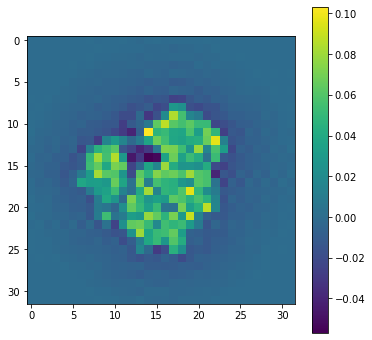

In [4]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"
og_v = Volume.load(vol_file, dtype=np.float64)
print("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")
print(f"Downsampling to {(nx,)*3}")
v = og_v.downsample(nx)

plt.imshow(v[0,16]); plt.colorbar()

In [5]:
if save_to_file:
    with mrcfile.new(out_dir + '/v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

Create the noise filter

In [6]:
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / nx * nx
    return (alpha * f1 + beta * f2) / 2.0

custom_noise_filter = FunctionFilter(noise_function)

And the CTF filters

In [7]:
# Create some CTF effects
pixel_size = 5 * 65 / nx  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]

Create the Simulation object (containing the simulated images)

2022-06-21 12:47:42,386 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-21 12:47:42,400 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:47:42,402 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.


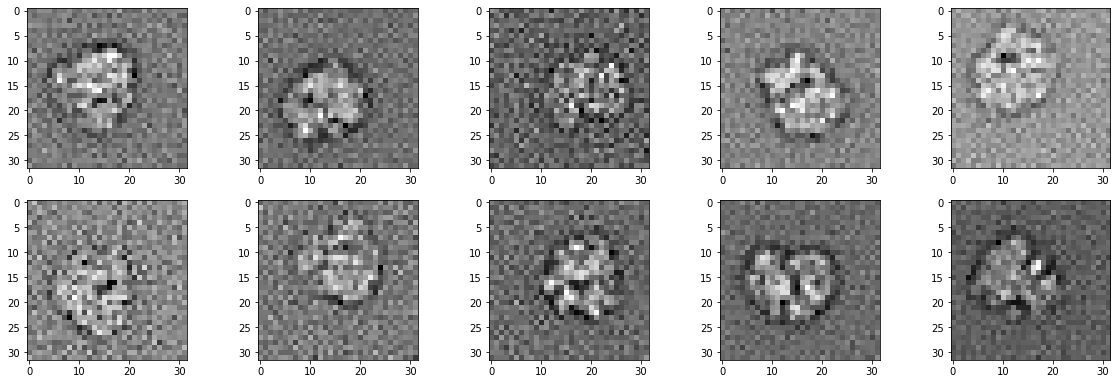

In [8]:
# Finally create the Simulation
src = Simulation(
    L=nx,
    n=N,
    vols=v,
    noise_filter= custom_noise_filter,
    unique_filters= ctf_filters
)
src.phase_flip()

# Peek
if interactive:
    src.images(0, 10).show()

Estimate the noise variance

2022-06-21 12:47:43,296 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:47:43,301 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:47:44,901 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:47:44,905 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.


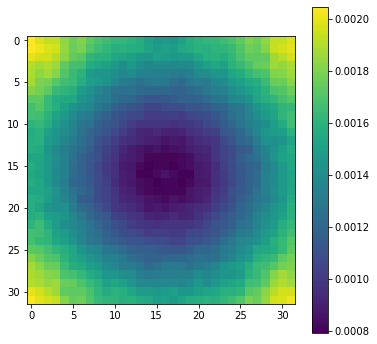

In [9]:
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
sigma_noise = jnp.sqrt(aiso_noise_estimator.filter.evaluate_grid(nx))

plt.imshow(sigma_noise)
plt.colorbar()

Extract the relevant information for reconstruction

2022-06-21 12:47:46,928 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:47:46,936 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-21 12:47:51,122 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-21 12:47:51,126 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.


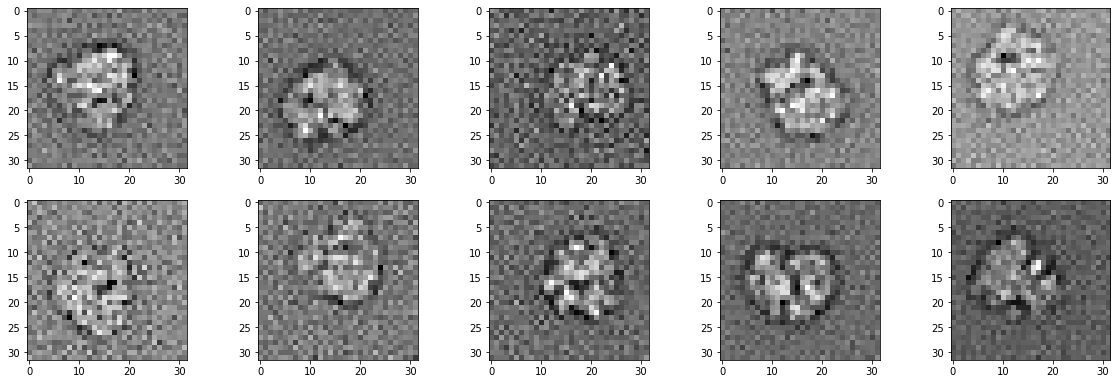

In [10]:
imgs_aspire, imgs_f_aspire, angles, shifts, ctf_params, x_grid, mask = get_params_from_aspire(src, pixel_size)

src.images(0, 10).show()

### And volume reconstruction with SGD

In [41]:
alpha = 1e-1
slice_obj = Slice(x_grid, mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [42]:
# Apply mask to iamges
imgs_f_aspire = imgs_f_aspire * mask

In [43]:
N_epochs = 100
batch_size = 100
step_size = 1e-6
grad_func = get_sgd_vol_ops(gradv_obj, angles, shifts, ctf_params, imgs_f_aspire.reshape(N,-1), sigma_noise.reshape(-1))
x0 = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

x = sgd(grad_func, N, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)

  sgd epoch 0: mean gradient = 14.922022721038058
  sgd epoch 10: mean gradient = 2.8724343712904155
  sgd epoch 20: mean gradient = 1.6848567369333562
  sgd epoch 30: mean gradient = 0.4913946279723232
  sgd epoch 40: mean gradient = 1.431107899323219
  sgd epoch 50: mean gradient = 1.0060131949510205
  sgd epoch 60: mean gradient = 0.6995279243952254
  sgd epoch 70: mean gradient = 1.215959060649187
  sgd epoch 80: mean gradient = 1.1246684855704243
  sgd epoch 90: mean gradient = 2.508551644401566


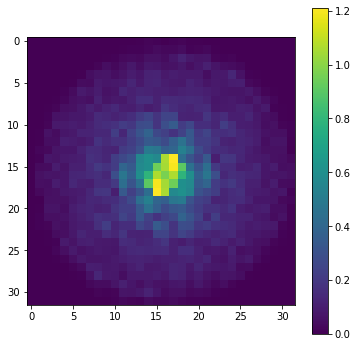

In [44]:
mip_z(jnp.fft.fftshift(jnp.abs(x))); plt.colorbar()

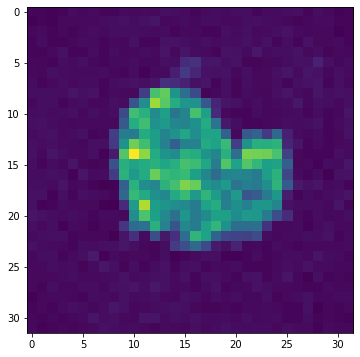

In [45]:
vol_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(x)))
mip_z(vol_rec)

In [46]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_sgd_noise.mrc', overwrite=True) as mrc:
        mrc.set_data(vol_rec.astype(np.float32))

### TODO

* Make sure that $\sigma_{noise}$ is estimated correctly
* Compare with reconstruction with wrong $\sigma_{noise}$ to make sure it makes sense
* play with different parameter values: step size, regularization parameter